In [1]:
# Imports
import collections
import itertools
import math

import numpy as np
import numba
import pandas as pd
import scipy.stats as st
import requests

import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint
from datetime import datetime as dt
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 18}
sns.set(rc=rc)
%matplotlib inline

# Shubhi Does Data: Are 1-0 wins really the mark of a champion?

### The Premise
There's a really common saying, "*1-0 wins* show strength and determination of a winning football team." The latest appearance was in an [ESPN FC article](http://www.espnfc.us/english-premier-league/23/blog/post/3025212/a-string-of-1-0-wins-is-a-hallmark-of-a-champion-and-chelsea-have-several). But is this really the case? Can we back this up with some [data](https://github.com/footballcsv)? This specific article even mentions that statistics don't show much correlation between champions and the number of *1-0 wins*. It's time to get a better understanding of this.

### The Approach
**Data Source:** We're going to look at 20 seasons of data (1993-2013) across the top five leagues during this time (EPL, La Liga, Bundesliga, Serie A, and Ligue 1).

**Methods:**

In [2]:
# Data import variables and helper functions
SOURCES = {'england': 'data/eng-england-master/', 'spain': 'data/es-espana-master/', 
           'germany': 'data/de-deutschland-master/', 'italy': 'data/it-italy-master/',
           'france': 'data/fr-france-master/'}
LEAGUE_NAME = {'england': '/1-premierleague.csv', 'spain': '/1-liga.csv',
               'germany': '/1-bundesliga.csv', 'italy': '/1-seriea.csv',
               'france': '/1-ligue1.csv'}

def get_file_src(season, country):
    '''
    Input: Season we're looking at the file source for, and country we're looking at.
    Output: File source of input season
    This helper function returns the file source for the given league results csv.
    '''
    # If we're looking for an England or Germany season, the file source is different
    if country in ['england', 'germany']:
        decade_folder = str(int(int(season) / 10) * 10) + 's'
        season_folder = season + '-' + "%02d" % ((int(season) + 1) % 100,) 
        # England's top league wasn't called Premier League until the 1993 season
        if country == 'england' and int(season) < 1992:
            return SOURCES[country] + decade_folder + '/' + season_folder + '/1-division1.csv'
        return SOURCES[country] + decade_folder + '/' + season_folder + LEAGUE_NAME[country]
    # Spain, Italy, or France
    else:
        season_folder = season + '-' + "%02d" % ((int(season) + 1) % 100,)
        # France's top league wasn't called Ligue 1 until the 2002 season
        if country == 'france' and int(season) < 2002:
            return SOURCES[country] + season_folder + '/1-division1.csv'
        return SOURCES[country] + season_folder + LEAGUE_NAME[country]

def get_data_frame(season, country):
    '''
    Input: Season we're looking at the file source for, and country we're looking at.
    Output: Pandas DataFrame with the results of a given league for a given season.
    '''
    source = get_file_src(season, country)
    # Germany has the round column in its data
    if country == 'germany' or int(season) < 1993:
        names = ['Round', 'Date', 'Home', 'Away', 'FT', 'HT']
        idx = 1
    else:
        names = ['Date', 'Home', 'Away', 'FT', 'HT']
        idx = 0
    if int(season) > 1992:
        df = pd.read_csv(source, engine='c', header=0, names=names,
                         converters={
                             idx: lambda x: dt.strptime(x, '%Y-%m-%d').date()
                         },
                         na_filter=False,
                         low_memory=False)
    else:
        df = pd.read_csv(source, engine='c', header=0, names=names,
                         na_filter=False,
                         low_memory=False)
    return df

In [3]:
# File Imports (they're a different file structure)
data = {country: {year: get_data_frame(str(year), country) for year in range(1993, 2014)} for country in SOURCES}

Now, this `data` variable is a multi-level dictionary where the keys are country and season and the value is a pandas DataFrame of results for that season, for that specific league.

Here's an example of such a DataFrame for the EPL in 2013.

In [4]:
data['england'][2013].head()

,Date,Home,Away,FT,HT
0,2013-08-17,Arsenal,Aston Villa,1-3,1-1
1,2013-08-17,Liverpool,Stoke,1-0,1-0
2,2013-08-17,Norwich,Everton,2-2,0-0
3,2013-08-17,Sunderland,Fulham,0-1,0-0
4,2013-08-17,Swansea,Man United,1-4,0-2


This looks pretty good.

We'll now write helper functions to determine the the number of *1-0 wins* each team has, as well as the final standing at the end of the season.

In [5]:
def final_points(df):
    '''
    Input: DataFrame for the results of a given season.
    Output: 2 dictionaries [Season, Team, Final Points, # of 1-0 Wins]
    '''
    points = {}
    one_zero_wins = {}
    for index, row in df.iterrows():
        home, away = row['Home'], row['Away']
        home_score, away_score = map(int, row['FT'].split('-'))
        # Tie
        if home_score == away_score:
            home_points, away_points = 1, 1
        # Home Win
        elif home_score > away_score:
            home_points, away_points = 3, 0
        # Away Win
        elif home_score < away_score:
            home_points, away_points = 0, 3
        # Update points
        if home in points:
            points[home] += home_points
        else:
            points[home] = home_points
        if away in points:
            points[away] += away_points
        else:
            points[away] = away_points
        # Update 1-0 wins
        home_1_0_wins, away_1_0_wins = 0, 0
        if home_score == 1 and away_score == 0:
            home_1_0_wins, away_1_0_wins = 1, 0
        elif home_score == 0 and away_score == 1:
            home_1_0_wins, away_1_0_wins = 0, 1
        if home in one_zero_wins:
            one_zero_wins[home] += home_1_0_wins
        else:
            one_zero_wins[home] = home_1_0_wins
        if away in one_zero_wins:
            one_zero_wins[away] += away_1_0_wins
        else:
            one_zero_wins[away] = away_1_0_wins
    return points, one_zero_wins

def sort_standings(points):
    '''
    This helper function takes a dictionary of point values, and returns the final standings of the season.
    '''
    points = points.items()
    standings = sorted(points, key=lambda x:x[1], reverse=True)
    return {standings[idx][0]: idx + 1 for idx in range(len(standings))}

def combine_data_df(data):
    '''
    Combine all of the data available to us into a nice and tidy DataFrame
    '''
    cols = ['League', 'Season', 'Team', 'Points', 'Standing', '1-0 Wins']
    df = pd.DataFrame(columns=cols)
    # For each country
    for country, seasons in data.iteritems():
        # For each season
        for season, results in seasons.iteritems():
            # Get the points and number of one_zero wins each team had per season
            points, one_zero_wins = final_points(results)
            # Also get the resultant standings
            standings = sort_standings(points)
            # Append each row to the overall DataFrame
            for team in points:
                df = df.append(pd.DataFrame(np.array([[country, season, team, points[team], 
                                       standings[team], one_zero_wins[team]]]),
                                       columns=cols),
                               ignore_index=True)
    df[['Season', 'Points', 'Standing', '1-0 Wins']] = df[['Season', 'Points', 'Standing', '1-0 Wins']].apply(pd.to_numeric)
    return df

In [6]:
# Let's run it now!
df = combine_data_df(data)
df.head()

,League,Season,Team,Points,Standing,1-0 Wins
0,italy,1993,Udinese,35,16,1
1,italy,1993,Genoa,40,14,2
2,italy,1993,Napoli,48,6,3
3,italy,1993,Lazio,61,4,2
4,italy,1993,Lecce,14,18,1


Now, let's do the easy thing: is there a correlation between `Points` and `1-0 Wins`?

In [7]:
points_wins_corr = df['Points'].corr(df['1-0 Wins'])
standing_wins_corr = df['Standing'].corr(df['1-0 Wins'])
standing_points_corr = df['Standing'].corr(df['Points'])
print('Correlation Value between Points and # of 1-0 Wins:\t%.2f' % points_wins_corr)
print('Correlation Value between Standing and # of 1-0 Wins:\t%.2f' % standing_wins_corr)
print('Correlation Value between Standing and Points:\t\t%.2f' % standing_points_corr)

Correlation Value between Points and # of 1-0 Wins:	0.42
Correlation Value between Standing and # of 1-0 Wins:	-0.35
Correlation Value between Standing and Points:		-0.90


The three correlation values tell us both some pretty interesting, revealing information, as well as some very obvious information at the same time. Let's focus on one at a time.

**Correlation between Points and # of *1-0 Wins***<br>
This is a moderately strong 0.42. In other words, there seems to be a slight relationship between the number of points a team has, and the number of *1-0 wins* they achieve. But wait, isn't that obvious? Teams need wins in order to get points, whether they're *1-0 wins* or not. In other words, this correlation value is pretty meaningless. We need a better way to look at the relationship.

**Correlation between Standing and # of *1-0 Wins***<br>
This is again a moderately strong 0.35. Yet, similar to the previous correlation value, this is not truly answering the question we're looking at. We're mostly interested in *1-0 wins* vs. other types of wins, or how often champions tend to churn out *1-0 wins*. We'll take a look at that in the next section, with a neat bar graph.

**Correlation between Standing and Points**<br>
This was an obvious one, and was more of a sanity check. The more points a team has, the higher it is in the league table, having an overall lower value rank (lesser value). Glad to see that we have a very strong correlation there.

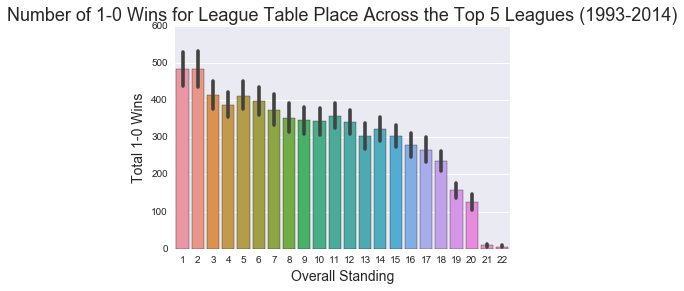

In [8]:
sns.barplot(x=df['Standing'], y=df['1-0 Wins'], estimator=sum)
plt.ylabel('Total 1-0 Wins')
plt.xlabel('Overall Standing')
plt.title('Number of 1-0 Wins for League Table Place Across the Top 5 Leagues (1993-2014)')

This shows a trend that we really expect (and the commentators have taught us so): the top teams tend to have more *1-0 Wins* than others. Yet, what we realize very quickly is that the number of wins is not the most important value to us, but more so, the percent of such wins out of the overall wins, or points (we can try both) that a team accumulates. This truly tell us the value of the grit and *ugly* wins that teams achieve.

The number of *1-0 Wins* is a pretty confusing statistic to look at since the top teams will generally have more wins overall, *1-0 Wins* or not.

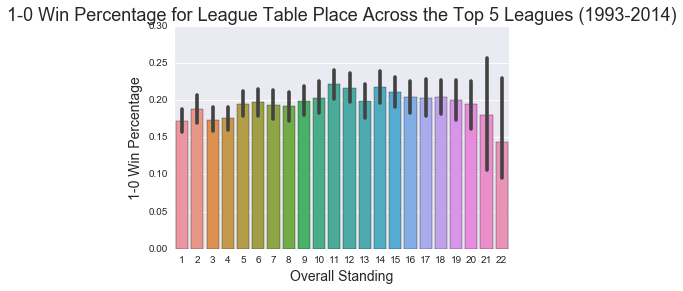

In [9]:
df['1-0 Win Percentage'] = df['1-0 Wins'] * 3.0 / df['Points']
sns.barplot(x=df['Standing'], y=df['1-0 Win Percentage'])
plt.ylabel('1-0 Win Percentage')
plt.xlabel('Overall Standing')
plt.title('1-0 Win Percentage for League Table Place Across the Top 5 Leagues (1993-2014)')

This visualization tells us a more accurate, but unfortunately, less beautiful result. We can see that there is not much of a correlation between overall league place, and the fraction of *1-0 Wins* a team pulls out over the course of a season. Looking at the correlation value between the two tells us the same again.

In [10]:
standing_win_perc_corr = df['Standing'].corr(df['1-0 Win Percentage'])
print('Correlation Value between Points and %% of 1-0 Wins:\t%.2f' % standing_win_perc_corr)

Correlation Value between Points and % of 1-0 Wins:	0.08


This measly 0.08 is truly a testament to how much *1-0 Wins* really matter to championship and top-level teams.

But maybe, it's different for each league? The author of the ESPN FC article mentioned above, Michael Cox, talks about this in reference to the EPL. Let's really push this myth to the test and see the breakdown, league by league, starting off with the EPL.

In [11]:
# EPL data
df_epl = df[df['League'] == 'england'].reset_index()
df_epl.head()

,index,League,Season,Team,Points,Standing,1-0 Wins,1-0 Win Percentage
0,398,england,1993,Oldham,40,21,2,0.150000
1,399,england,1993,Aston Villa,57,10,6,0.315789
2,400,england,1993,Ipswich,43,18,5,0.348837
3,401,england,1993,Wimbledon,65,6,7,0.323077
4,402,england,1993,Liverpool,60,8,2,0.100000


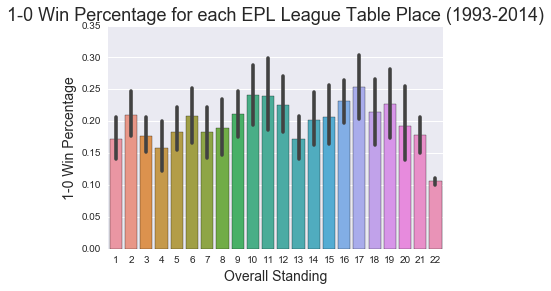

In [12]:
sns.barplot(x=df_epl['Standing'], y=df_epl['1-0 Win Percentage'])
plt.ylabel('1-0 Win Percentage')
plt.xlabel('Overall Standing')
plt.title('1-0 Win Percentage for each EPL League Table Place (1993-2014)')

Wow, this is more volatile, but we are dealing with fewer matches. What about the correlation value? Is there any change?

In [13]:
standing_win_perc_corr = df_epl['Standing'].corr(df_epl['1-0 Win Percentage'])
print('EPL Correlation Value between Points and %% of 1-0 Wins:\t%.2f' % standing_win_perc_corr)

EPL Correlation Value between Points and % of 1-0 Wins:	0.12


There's barely a difference. Let's add more matches to our analysis: we're going back to the 60s.

In [14]:
epl_data = {'england': {year: get_data_frame(str(year), 'england') for year in range(1960, 2014)}}
df_old_epl = combine_data_df(epl_data)
df_old_epl.head()

,League,Season,Team,Points,Standing,1-0 Wins
0,england,1960,Manchester United,63,6,1
1,england,1960,West Ham United,49,17,1
2,england,1960,Burnley,73,4,3
3,england,1960,Nottingham Forest,51,13,2
4,england,1960,Aston Villa,60,8,1


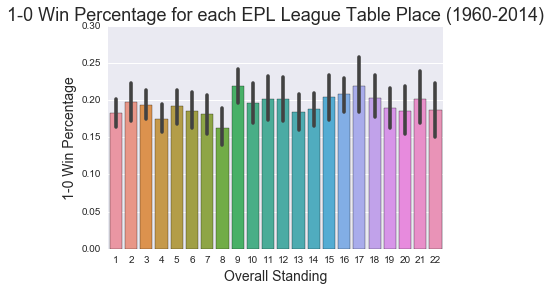

In [15]:
df_old_epl['1-0 Win Percentage'] = df_old_epl['1-0 Wins'] * 3.0 / df_old_epl['Points']
sns.barplot(x=df_old_epl['Standing'], y=df_old_epl['1-0 Win Percentage'])
plt.ylabel('1-0 Win Percentage')
plt.xlabel('Overall Standing')
plt.title('1-0 Win Percentage for each EPL League Table Place (1960-2014)')

In [16]:
standing_win_perc_corr_old = df_old_epl['Standing'].corr(df_old_epl['1-0 Win Percentage'])
print('EPL Correlation Value between Points and %% of 1-0 Wins:\t%.2f' % standing_win_perc_corr_old)

EPL Correlation Value between Points and % of 1-0 Wins:	0.04


Ugh, this is even less relevant.

But, I have one last experiment that we can try. Let's instead track the highest number of consecutive *1-0 Wins* for each team, in each season. After all, that is truly the context in which Sir Alex Ferguson mentioned the idea of *1-0 Wins*. 

"How many times have I said to you about 1-0? What does it mean? It means championship form. I don't mind the 1-0s, I really don't, because it tells you we are determined, we're going to defend, do the right things and play as a team." - Sir Alex Ferguson



In [17]:
def one_zero_string(df):
    '''
    Input: DataFrame for the results of a given season.
    Output: 1 dictionary of [Season, Team, # of consecutive 1-0 Wins]
    Given a DataFrame filled with all results data, let's calculate the max number of consecutive one_zero wins that
    a team achieves.
    '''
    teams = df['Home'].unique()
    consecutive_one_zero_wins = {team: 0 for team in teams}
    # We have to calculate this for each team separately
    for team in teams[::-1]:
        max_wins = 0
        df_team = df[(df['Home'] == team) | (df['Away'] == team)].reset_index()
        # Now that we're looking only at one specific team, we can continue our calculation
        for index, row in df_team.iterrows():
            home, away = row['Home'], row['Away']
            home_score, away_score = map(int, row['FT'].split('-'))
            if home == team and home_score is 1 and away_score is 0:
                max_wins += 1
            elif away == team and away_score is 1 and home_score is 0:
                max_wins += 1
            else:
                if consecutive_one_zero_wins[team] < max_wins:
                    consecutive_one_zero_wins[team] = max_wins
                max_wins = 0
    return consecutive_one_zero_wins
            
def combine_data_df(data):
    '''
    Combine all of the data available to us into a nice and tidy DataFrame
    '''
    cols = ['League', 'Season', 'Team', 'Points', 'Standing', '1-0 Wins', 'Max Consecutive 1-0 Wins']
    df = pd.DataFrame(columns=cols)
    # For each country
    for country, seasons in data.iteritems():
        # For each season
        for season, results in seasons.iteritems():
            # Get the points and number of one_zero wins each team had per season
            points, one_zero_wins = final_points(results)
            # Also get the resultant standings
            standings = sort_standings(points)
            # Also get the max number of consecutive 1-0 wins for each team
            consecutive_one_zero_wins = one_zero_string(results)
            # Append each row to the overall DataFrame
            for team in points:
                df = df.append(pd.DataFrame(np.array([[country, season, team, points[team], 
                                       standings[team], one_zero_wins[team], consecutive_one_zero_wins[team]]]),
                                       columns=cols),
                               ignore_index=True)
    df[['Season', 'Points', 'Standing', '1-0 Wins', 'Max Consecutive 1-0 Wins']] = df[['Season', 'Points', 'Standing', '1-0 Wins', 'Max Consecutive 1-0 Wins']].apply(pd.to_numeric)
    return df

In [18]:
# Let's run it now!
df_old_epl = combine_data_df(epl_data)
df_old_epl.head()

,League,Season,Team,Points,Standing,1-0 Wins,Max Consecutive 1-0 Wins
0,england,1960,Manchester United,63,6,1,1
1,england,1960,West Ham United,49,17,1,1
2,england,1960,Burnley,73,4,3,1
3,england,1960,Nottingham Forest,51,13,2,1
4,england,1960,Aston Villa,60,8,1,1


Time for the final test.

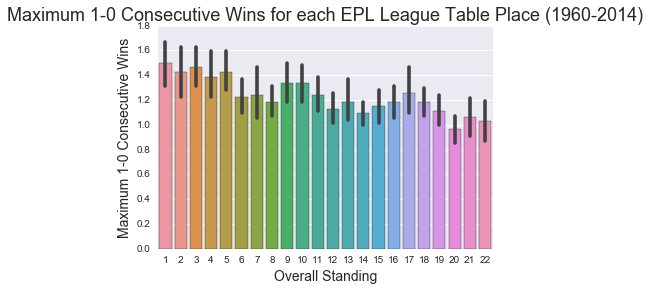

In [19]:
sns.barplot(x=df_old_epl['Standing'], y=df_old_epl['Max Consecutive 1-0 Wins'])
plt.ylabel('Maximum 1-0 Consecutive Wins')
plt.xlabel('Overall Standing')
plt.title('Maximum 1-0 Consecutive Wins for each EPL League Table Place (1960-2014)')

Ohohoho.

In [20]:
standing_con_win_corr_old = df_old_epl['Points'].corr(df_old_epl['Max Consecutive 1-0 Wins'])
print('EPL Correlation Value between Points and Max Number of Consecutive 1-0 Wins:\t%.2f' % standing_con_win_corr_old)

EPL Correlation Value between Points and Max Number of Consecutive 1-0 Wins:	0.22


Eh, this is too small of a correlation value to suggest anything, given that there is confounding taking place regarding the fact that the higher points teams do indeed win more matches. It's pointless. The pundits are wrong. *1-0 Wins* are not really the hallmark of champions at all.

I hate to leave you all here, so in the next post, we'll look into determining a measure that really is the hallmark of champions.